In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [21]:
#load datasets
am_df = pd.read_csv("data/american_stock.csv")
eu_df = pd.read_csv("data/european_index.csv")
rf_df = pd.read_csv("data/FEDFUNDS.csv")
european_index_df = pd.read_csv("data/ndx_historical.csv")


In [22]:
rf_df["DATE"] = pd.to_datetime(rf_df["DATE"], format="%Y-%m-%d")

In [23]:
volatility_intervals = 100
eu_df["date"] = pd.to_datetime(eu_df["date"], format="%Y%m%d")
eu_df["exdate"] = pd.to_datetime(eu_df["exdate"], format="%Y%m%d")
eu_df["rf_join_date"] = pd.to_datetime(eu_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
eu_df["tte"] = eu_df["exdate"] - eu_df["date"]
european_index_df["Date"] = pd.to_datetime(european_index_df["Date"])
european_index_df["volatility"] = european_index_df["Close/Last"].rolling(volatility_intervals).std() / european_index_df["Close/Last"]
eu_df = pd.merge(eu_df, rf_df, left_on="rf_join_date", right_on="DATE")
eu_df = pd.merge(eu_df, european_index_df, left_on="date", right_on="Date")
eu_df = eu_df[["date", "exdate", "symbol", "cp_flag", "strike_price", "best_bid", "best_offer", "tte", "Close/Last", "FEDFUNDS", "volatility"]]
eu_df["modeled_price"] = 0 #temporary placeholder
eu_df.head()

,date,exdate,symbol,cp_flag,strike_price,best_bid,best_offer,tte,Close/Last,FEDFUNDS,volatility,modeled_price
0,2015-01-02,2015-01-09,NDX 150109C3100000,C,3100000,1124.9,1134.0,7 days,4230.24,0.11,0.027469,0
1,2015-01-02,2015-01-09,NDX 150109C3125000,C,3125000,1099.9,1109.0,7 days,4230.24,0.11,0.027469,0
2,2015-01-02,2015-01-09,NDX 150109C3150000,C,3150000,1074.9,1084.0,7 days,4230.24,0.11,0.027469,0
3,2015-01-02,2015-01-09,NDX 150109C3175000,C,3175000,1049.9,1059.0,7 days,4230.24,0.11,0.027469,0
4,2015-01-02,2015-01-09,NDX 150109C3200000,C,3200000,1024.9,1034.0,7 days,4230.24,0.11,0.027469,0


In [101]:
am_df = am_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style"]]
am_df["date"] = pd.to_datetime(am_df["date"], format="%Y%m%d")
am_df["exdate"] = pd.to_datetime(am_df["exdate"], format="%Y%m%d")
am_df["tte"] = am_df["exdate"] - am_df["date"]
am_df["rf_join_date"] = pd.to_datetime(am_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
am_df = pd.merge(am_df, rf_df, left_on="rf_join_date", right_on="DATE")
am_df = am_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style", "tte", "Close/Last", "FEDFUNDS"]]


<ipython-input-101-a0168d33d784>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_df["date"] = pd.to_datetime(am_df["date"], format="%Y%m%d")
<ipython-input-101-a0168d33d784>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_df["exdate"] = pd.to_datetime(am_df["exdate"], format="%Y%m%d")
<ipython-input-101-a0168d33d784>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

KeyError: "['Close/Last'] not in index"

In [14]:
#Current assumptions: risk-neutral, a set volatility and that FED rate is essentially the risk-free rate

def simple_european_binomial_model(n_steps, vol, underlying_price, strike, tte, int_rate, call=True):
    """
    Returns the modeled price of a European options contract. 
    n_steps: number of steps
    vol: volatility (in float)
    underlying_price: initial stock price
    strike: strike price of option
    tte: time to expiration of contract (in days)
    int_rate: risk-free interest rate
    call: boolean True if call, False otherwise
    """
    dt = (tte/365)/n_steps
    u = math.exp(vol*math.sqrt(dt))
    d = 1/u
    p = (math.exp(int_rate*dt)-d)/(u-d)
    
    stock_prices = [] #possible stock prices at the latest time
    options_prices = [] #options values at the respective times
    for i in range(0,n_steps+1):
        stock_prices.append(underlying_price*(u**(n_steps-i))*(d**i))
        if call:
            options_prices.append(max(0,stock_prices[i]-strike))
        else:
            options_prices.append(max(0,strike-stock_prices[i]))
    #combine options data backwards in pairs
    counter = n_steps-1
    while counter > -1:
        for i in range(counter+1):
            price = math.exp(-int_rate*dt)*(p*options_prices[i] + (1-p)*options_prices[i+1])
            options_prices[i] = price
        counter-=1
    return options_prices[0]

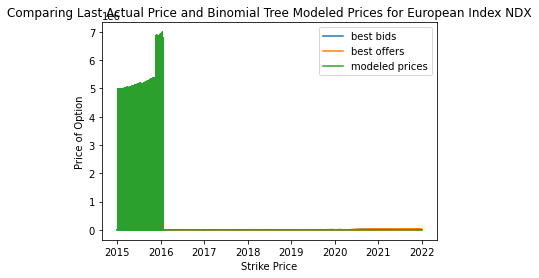

In [38]:
#To test other models, just change the parameters needed, docs will be added later
for i in range(0,10000): 
  vol = eu_df["volatility"][i]
  stock_price = eu_df["Close/Last"][i]
  strike = eu_df["strike_price"][i]/1000
  tte = eu_df["tte"][i].days
  int_rate = eu_df["FEDFUNDS"][i]
  call = True if eu_df["cp_flag"][i] == 'C' else False
  eu_df["modeled_price"][i] = simple_european_binomial_model(30,vol,stock_price,strike,tte,int_rate,call)


plt.plot(eu_df['date'].to_numpy(),eu_df['best_bid'].to_numpy(),label="best bids")
plt.plot(eu_df['date'].to_numpy(),eu_df['best_offer'].to_numpy(),label="best offers")
plt.plot(eu_df['date'].to_numpy(),eu_df["modeled_price"].to_numpy(),label="modeled prices")
plt.title('Comparing Last Actual Price and Binomial Tree Modeled Prices for European Index NDX')
plt.ylabel('Price of Option')
plt.xlabel('Strike Price')
plt.legend()
plt.show()

In [37]:
eu_df.head()

,date,exdate,symbol,cp_flag,strike_price,best_bid,best_offer,tte,Close/Last,FEDFUNDS,volatility,modeled_price
0,2015-01-02,2015-01-09,NDX 150109C3100000,C,3100000,1124.9,1134.0,7 days,4230.24,0.11,0.027469,1136.772833
1,2015-01-02,2015-01-09,NDX 150109C3125000,C,3125000,1099.9,1109.0,7 days,4230.24,0.11,0.027469,1111.825517
2,2015-01-02,2015-01-09,NDX 150109C3150000,C,3150000,1074.9,1084.0,7 days,4230.24,0.11,0.027469,1086.878201
3,2015-01-02,2015-01-09,NDX 150109C3175000,C,3175000,1049.9,1059.0,7 days,4230.24,0.11,0.027469,1061.930885
4,2015-01-02,2015-01-09,NDX 150109C3200000,C,3200000,1024.9,1034.0,7 days,4230.24,0.11,0.027469,1036.983569


In [15]:
#Current assumptions: #Current assumptions: risk-neutral, a set volatility and that FED rate is essentially the risk-free rate
def american_binomial_model(n_steps, vol, underlying_price, strike, tte, int_rate, call=True):
    """
    Returns the modeled price of an American options contract. 
    n_steps: number of steps
    vol: volatility (in float)
    underlying_price: initial stock price
    strike: strike price of option
    tte: time to expiration of contract (in days)
    int_rate: risk-free interest rate
    call: boolean True if call, False otherwise
    """
    dt = (tte/365)/n_steps
    u = math.exp(vol*math.sqrt(dt))
    d = 1/u
    p = (math.exp(int_rate*dt)-d)/(u-d)
    #initialize arrays to hold stock/options_payoff values 
    stock_prices = [0]*(n_steps+1)
    for i in range(1,n_steps+1):
        stock_prices[i]= [0]*(i+1)
    options_payoff = stock_prices.copy()
    stock_prices[0] = underlying_price
    #calculate possible stock prices 
    for i in range(1,n_steps+1):
        for j in range(i+1):
            stock_prices[i][j] = underlying_price*(u**(i-j))*(d**j)
            
    #calculate options payoffs at the respective times depending on stock prices
    for i in range(1,n_steps+1):
        for j in range(i+1):
            if call:
                options_payoff[i][j] = max(0,stock_prices[i][j]-strike)
            else:
                options_payoff[i][j] = max(0,strike-stock_prices[i][j])
    
    #calculate max(options payoff if exercised early, option value)
    option_value = options_payoff[:]
    for i in range(n_steps-1,0,-1):
        for j in range(i+1):
            option_value[i][j] = max(options_payoff[i][j], (math.exp(-int_rate * dt)*(p * option_value[i+1][j] + (1-p)*option_value[i+1][j+1])))  
    return math.exp(-int_rate*dt)*(p*option_value[1][0] + (1-p)*option_value[1][1])
        # Calculate option values at earlier times

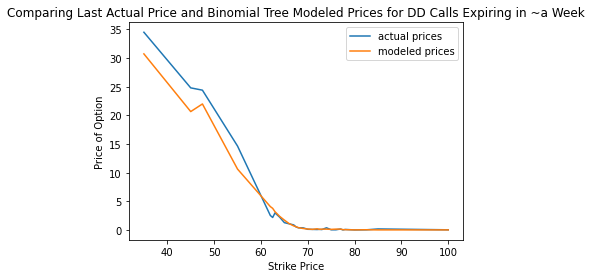

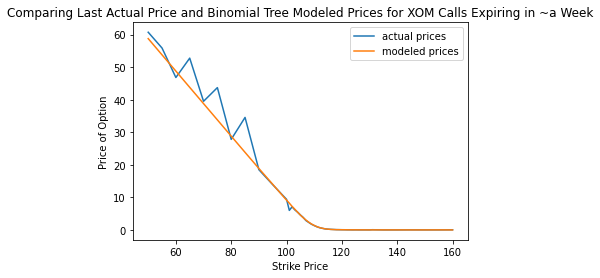

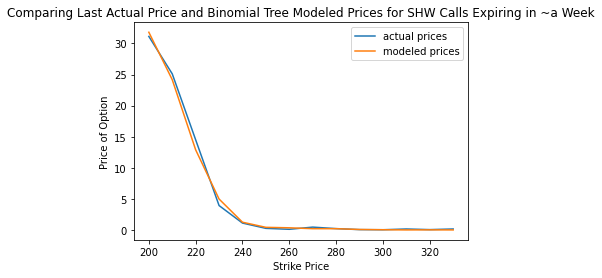

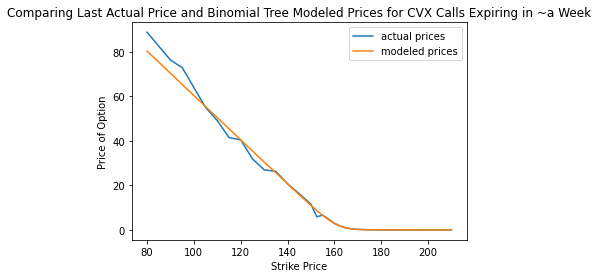

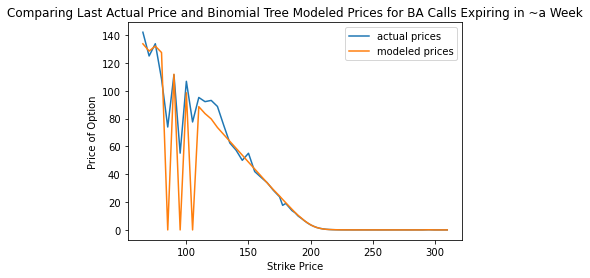

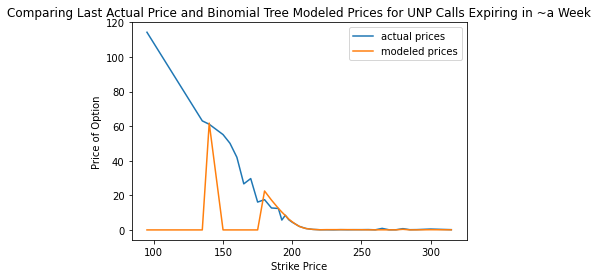

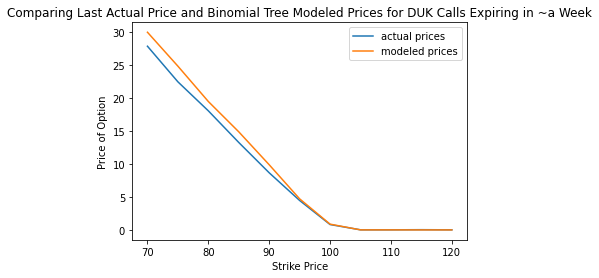

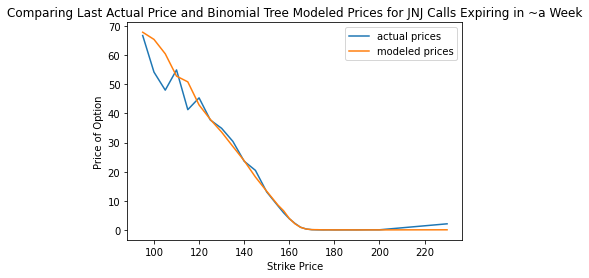

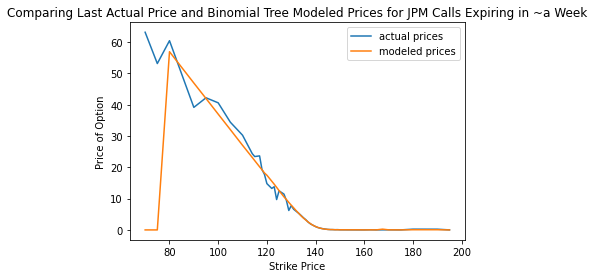

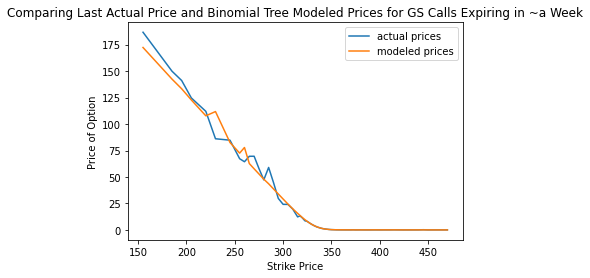

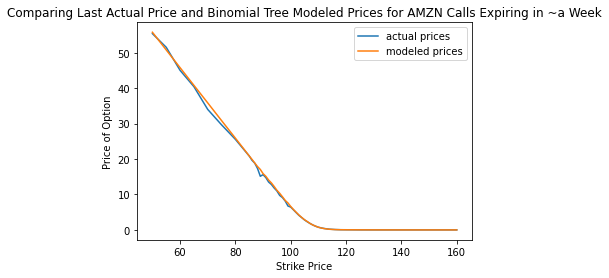

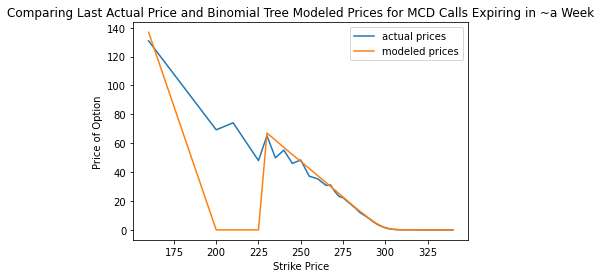

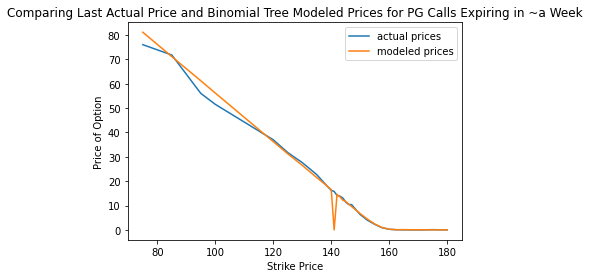

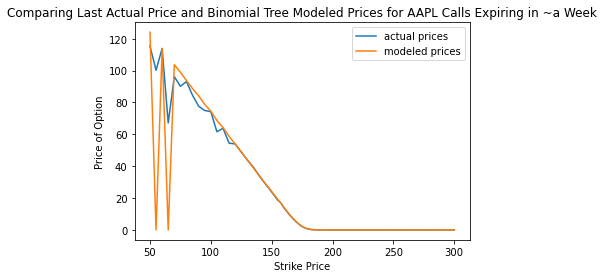

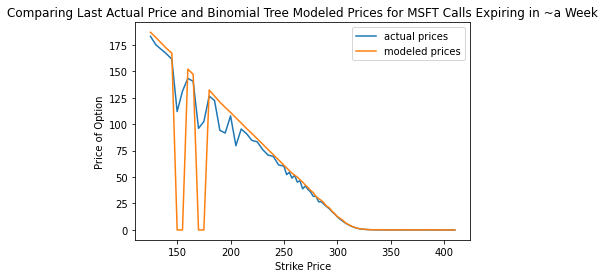

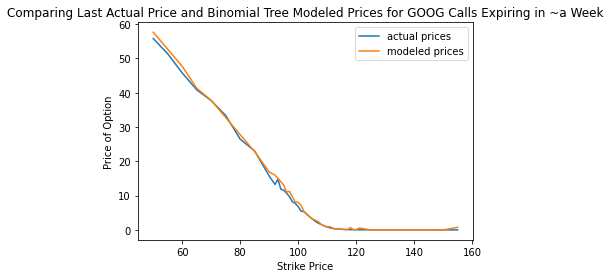

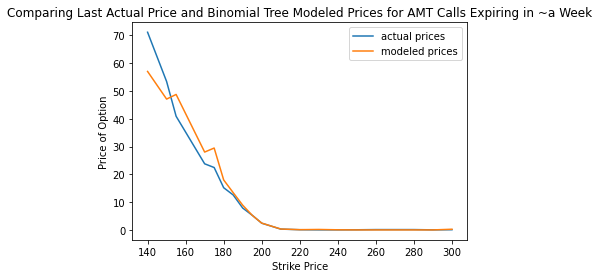

In [16]:
int_rate = 0.0344 #risk free interest rate today
def compare(ticker,date):
    """
    Generates plots comparing the modeled prices from the Binomial Model Tree to 
    actual stock data.
    ticker: ticker for the stock
    date: options expiration date
    """
    formatted_date = datetime.date(int(date[0:4]),int(date[5:7]),int(date[8::]))
    tte = formatted_date - datetime.date.today()
    stock = yf.Ticker(ticker)
    stock_price = stock.info['currentPrice']
    opt_chain = stock.option_chain(date)
    calls = opt_chain.calls
    calls["modeled_price"] = 0
    for i in range(0,calls.shape[0]):
        calculated_price = american_binomial_model(30,calls['impliedVolatility'][i],stock_price,calls['strike'][i],tte.days,int_rate,True)
        calls["modeled_price"][i] = calculated_price if (calculated_price < 2000 and calculated_price > 0) else 0
    plt.plot(calls['strike'].to_numpy(),calls['lastPrice'].to_numpy(),label="actual prices")
    plt.plot(calls['strike'].to_numpy(),calls["modeled_price"].to_numpy(),label="modeled prices")
    plt.title('Comparing Last Actual Price and Binomial Tree Modeled Prices for ' + ticker + ' Calls Expiring in ~a Week')
    plt.ylabel('Price of Option')
    plt.xlabel('Strike Price')
    plt.legend()
    plt.show()
    return 


stocks = {
    "DD":'2023-05-19', #Energy Sector
    "XOM":'2023-05-19', #Energy Sector
    "SHW":'2023-05-19', #Materials Sector
    "CVX":'2023-05-19', #Materials Sector
    "BA":'2023-05-19', #Industrial Sector
    "UNP":'2023-05-19', #Industrial Sector
    "DUK": '2023-05-19', #Healthcare
    "JNJ": '2023-05-19', #Healthcare
    "JPM": '2023-05-19', #Financial
    "GS" :'2023-05-19', #Financial
    "AMZN" :'2023-05-19', #Consumer Discretionary Sector
    "MCD" :'2023-05-19', #Consumer Discretionary Sector
    "PG" :'2023-05-19',#Consume Staples Sector
    "AAPL":'2023-05-19', #Tech Sector
    "MSFT": '2023-05-19',#Tech Sector
    "GOOG":'2023-05-19', #Communication Sector
    "AMT": '2023-05-19', #Real Estate
    }

for key in stocks:
    compare(key,'2023-05-19')